# Data Analysis for Inverse Observation Data Assimilation of Lorenz96
This notebook analyzes the paper's data and reproduces the plots.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="" # everything here can run on CPU
import warnings
warnings.filterwarnings('ignore')
from functools import partial
import numpy as np
import numpy.linalg as la
import scipy
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jla
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

from dynamical_system import Lorenz96
from analysis_util import (
    integrate_lorenz96_xr, 
    compute_l1_error_lorenz96, 
    adjust_row_labels, 
    plot_colors, 
    load_da_results,
)

# create figure directory
! mkdir -p figures

## Copy data from Google cloud

This requires [gsutil](https://cloud.google.com/storage/docs/gsutil).

In [2]:
!gsutil cp -r gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/ /tmp

Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_baselineinit_hybridopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_baselineinit_obsopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_invobsinit_hybridopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_invobsinit_obsopt.nc...
\ [4 files][ 43.7 MiB/ 43.7 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/lorenz96_baselineinit_hybridopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation

## Load data

In [3]:
path = '/tmp/invobs-da-results'

filenames = [
    'lorenz96_baselineinit_obsopt.nc',
    'lorenz96_baselineinit_hybridopt.nc',
    'lorenz96_invobsinit_obsopt.nc',
    'lorenz96_invobsinit_hybridopt.nc',
]
retained_variables = [
    'f_vals',
    'eval_vals',
    'X0_ground_truth',
    'X0_opt',
    'X0_init',
]
retained_attrs = [
    'observe_every',
    'grid_size',
    'num_time_steps',
    'dt',
]

full_filenames = [os.path.join(path, filename) for filename in filenames]
ds = load_da_results(full_filenames, retained_variables, retained_attrs)

## Data assimilation initialization samples

Comparison of initialization schemes.

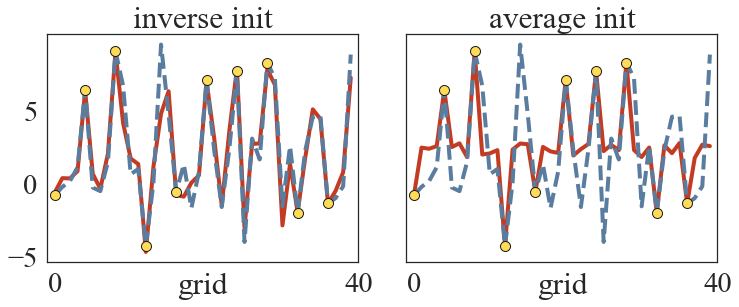

In [4]:
sns.set(font_scale=2.6)
sns.set_style('white')
plt.rc('font', **{'family': 'Times New Roman'})

plt.rc(
    'axes', 
    prop_cycle=(
        cycler('color', [plot_colors['r'], plot_colors['b']]) 
        + cycler('linestyle', ['-', '--'])
    ),
)
da_init = ds[['X0_init','X0_ground_truth']].to_array()
g =  (
    da_init
    .sel(opt_space='observation', n=5, init=['invobs', 'baseline'])
    .plot(x='x', col='init', hue='variable', lw=4, size=5, add_legend=False)
)

observed = da_init.sel(
    opt_space='observation', 
    n=5, 
    variable='X0_ground_truth',
)[:, ::4]
observed_grid_points = np.arange(0, 40, 4)

plt.xlim(-1,40)
col_labels = ['inverse init', 'average init']
g.set_axis_labels('', '')
[ax.set_title(t) for ax, t in zip(g.axes.ravel(), col_labels)]
[ax.set_yticks([-5, 0, 5]) for ax in g.axes.ravel()]
[ax.set_xticks([0, 40]) for ax in g.axes.ravel()]
[ax.set_xlabel('grid', labelpad=-25) for ax in g.axes.ravel()]
# g.set_titles('')
for i, init_method in enumerate(da_init.init.values):
  g.axes[0,i].plot(
      observed_grid_points, 
      observed.sel(init=init_method).data, 
      ls='None', 
      marker='o', 
      markersize=10, 
      color=plot_colors['y'], 
      markeredgecolor='k',
  )
g.fig.tight_layout()

plt.savefig('figures/da_init_lorenz96.pdf', bbox_inches='tight', pad_inches=0.1)

## Forecast quality

In [5]:
lorenz96 = Lorenz96(
    grid_size=ds.attrs['grid_size'],
    observe_every=ds.attrs['observe_every'],
    dt=ds.attrs['dt'],
)

In [6]:
X0_da = ds[['X0_ground_truth', 'X0_init', 'X0_opt']].to_array('data_type') \
.assign_coords({'data_type': ['gt', 'init', 'opt']}) 

In [7]:
X_da = integrate_lorenz96_xr(lorenz96, X0_da, 20)

In [8]:
relative_scale = 166.28 # average L1 norm over independent samples
l1_error = compute_l1_error_lorenz96(X_da, 'gt', scale=relative_scale)

In [9]:
l1_error_stacked = (    
    l1_error
    .sel(opt_space=['observation', 'hybrid'])
    .mean(dim='n')
    .sel(data_type='opt', drop=True)
    .assign_coords(
        {
            't': lorenz96.dt * np.arange(l1_error.sizes['t']), 
            'init': [s.split('_')[0] for s in l1_error.init.values],
        },
    )
    .stack(opt_method=['init', 'opt_space'])
)

In [10]:
tuple_labels = l1_error_stacked.opt_method.values
concat_labels = [ a + ' init' + ' / ' + b + ' opt' for a,b in tuple_labels]
l1_error_stacked = l1_error_stacked.assign_coords({'opt_method': concat_labels})

In [11]:
# select to have a custom sort of the optimization methods
l1_error_stacked = l1_error_stacked.sel(
    opt_method=[
      'invobs init / observation opt',
      'invobs init / hybrid opt',
      'baseline init / observation opt',
      'baseline init / hybrid opt',
    ]
)

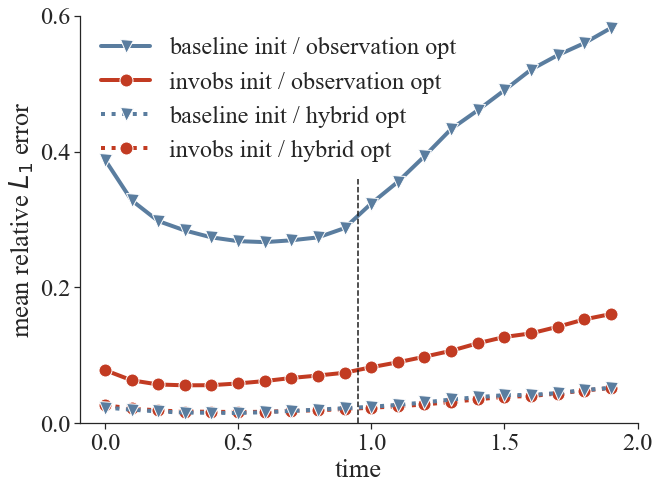

In [12]:
plt.figure(figsize=(10, 7.5))
sns.set(font_scale=2.2)
sns.set_style('ticks')
plt.rc('font', **{'family': 'Times New Roman'})

plt.rc(
    'axes', 
    prop_cycle=(
        cycler('color', [plot_colors['r']]*2 + [plot_colors['b']]*2) 
        + cycler('linestyle', ['-', 'dotted']*2)
        + cycler('marker', ['o', 'o', 'v', 'v'])
    ),
)

time_steps = l1_error_stacked.coords['t'].values
ax = plt.subplot(1,1,1)
for opt_method in l1_error_stacked.opt_method.values:
  ax.plot(
      time_steps, 
      l1_error_stacked.sel(opt_method=opt_method).values,
      markersize=13,
      markeredgecolor='white', 
      lw=4,
      label=opt_method,
  )

sns.despine()
plt.xlabel('time')
plt.ylabel('mean relative $L_1$ error')
plt.ylim(0, 0.6)
plt.axvline(x=9.5 * lorenz96.dt, ymax=0.6, color='k', ls='--')
plt.title('')
plt.xticks(np.arange(0, 2.1, 0.5))
plt.yticks(np.arange(0, 0.61, 0.2))

# plt.legend(frameon=False)
handles, labels = ax.get_legend_handles_labels()
line_ordering = [2, 0, 3, 1] # legend ordering according to appearance in plot
reordered_handles = [handles[i] for i in line_ordering]
reordered_labels = [labels[i] for i in line_ordering]
ax.legend(reordered_handles, reordered_labels, frameon=False)

plt.savefig(
    'figures/da_lorenz96_invobs.pdf', 
    bbox_inches='tight', 
    pad_inches=0.1,
)

### Summary stats
Compare forecast performance on the first forecast state relative to baseline init and optimization method.

In [13]:
summary_stats = l1_error.sel(data_type='opt', t=11).mean(dim='n') / l1_error.sel(data_type='opt', t=11, init='baseline', opt_space='observation').mean(dim='n')

In [14]:
print(
    summary_stats.sel(opt_space='observation', init='baseline').values,
    summary_stats.sel(opt_space='hybrid', init='baseline').values,
    summary_stats.sel(opt_space='observation', init='invobs').values,
    summary_stats.sel(opt_space='hybrid', init='invobs').values,
)

1.0 0.07642817 0.25266525 0.07028136


## Significance test between trajectories

Perform a Z-test to evaluate significance level between optimization methods for the two initialization schemes.

### Inverse observation initialization

In [15]:
time_step = 11 # beginning of forecast window
num_samples = l1_error.sizes['n']
l1_error_inv = l1_error.sel(init='invobs', data_type='opt')
diff_l1_error = (
    l1_error_inv.sel(opt_space='observation') 
  - l1_error_inv.sel(opt_space='hybrid')
)
m = diff_l1_error.sel(t=time_step).mean(dim='n')
s = diff_l1_error.sel(t=time_step).std(dim='n')
Z = m / (s / np.sqrt(num_samples))
p = scipy.stats.norm.sf(np.abs(Z))
print('Z-value', Z.values)
print('p-value', p)

Z-value 3.7605415818595267
p-value 8.477294378820626e-05


### Baseline initialization

In [16]:
time_step = 11 # beginning of forecast window
num_samples = l1_error.sizes['n']
l1_error_inv = l1_error.sel(init='baseline', data_type='opt')
diff_l1_error = (
    l1_error_inv.sel(opt_space='observation') 
  - l1_error_inv.sel(opt_space='hybrid')
)
m = diff_l1_error.sel(t=time_step).mean(dim='n')
s = diff_l1_error.sel(t=time_step).std(dim='n')
Z = m / (s / np.sqrt(num_samples))
p = scipy.stats.norm.sf(np.abs(Z))
print('Z-value', Z.values)
print('p-value', p)

Z-value 13.75386441553203
p-value 2.4140100201680256e-43


## Assimilated trajectories

In [17]:
baseline = (
    X_da
    .sel(data_type=['opt', 'gt'], opt_space='observation', init='baseline')
    .reset_coords(['opt_space', 'init'], drop=True)
)
invobs = (
    X_da
    .sel(data_type=['opt', 'gt'], opt_space='hybrid', init='invobs')
    .reset_coords(['opt_space', 'init'], drop=True)
)

forecast_comparison = (
    xr.concat([invobs, baseline], dim='da_method')
    .assign_coords(
        da_method=['invobs', 'baseline'], 
        t=lorenz96.dt * np.arange(baseline.sizes['t']),
    )
)

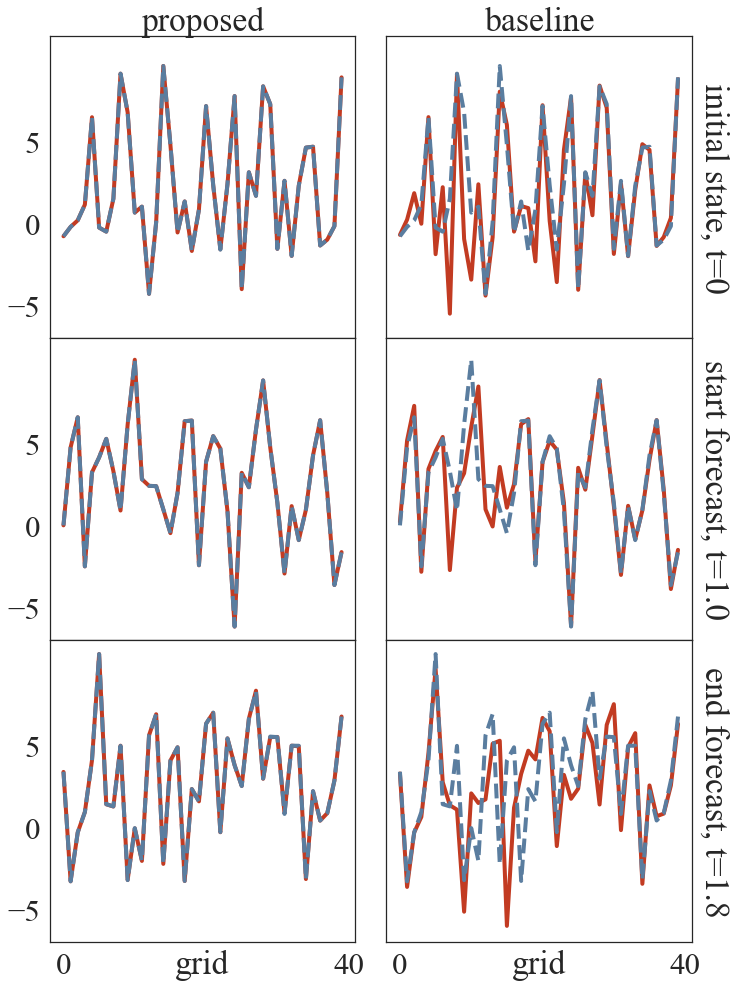

In [18]:
sns.set(font_scale=2.8)
sns.set_style('white')
plt.rc('font', **{'family': 'Times New Roman'})
plt.rc(
    'axes', 
    prop_cycle=(
        cycler('color', [plot_colors['r'], plot_colors['b']]) 
        + cycler('linestyle', ['-', '--'])
    ),
)
g = (
    forecast_comparison
    .isel(n=5, t=[0, 10, 18])
    .plot(
        x='x', 
        row='t', 
        hue='data_type', 
        col='da_method', 
        lw=4, 
        size=5, 
        add_legend=False,
    )
)

g.set_axis_labels('', '')
col_labels = ['proposed', 'baseline'] 
[ax.set_title(t) for ax, t in zip(g.axes.ravel(), col_labels)]
row_labels = [
    'initial state, t=0', 
    'start forecast, t=1.0', 
    'end forecast, t=1.8',
]
adjust_row_labels(g, row_labels)
[ax.set_yticks([-5, 0, 5]) for ax in g.axes.ravel()]
[ax.set_xticks([0, 40]) for ax in g.axes.ravel()]
for ax in g.axes.ravel()[-2:]:
  ax.set_xlabel('grid', labelpad=-30)
plt.subplots_adjust(hspace=0, wspace=0.1)

plt.savefig(
    'figures/forecast_results_lorenz96.pdf', 
    bbox_inches='tight', 
    pad_inches=0.1,
)